In [1]:
# @title Cell 1: 環境設定與函式庫匯入（修正版）
!pip install --upgrade opacus -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader

# --- 環境設定 ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

print("✅ Cell 1: 環境與函式庫準備就緒。")
import opacus
print(f"PyTorch/Opacus 版本: {torch.__version__} / {opacus.__version__}")
print(f"CUDA 是否可用: {torch.cuda.is_available()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
✅ Cell 1: 環境與函式庫準備就緒。
PyTorch/Opacus 版本: 2.6.0+cu124 / 1.5.4
CUDA 是否可用: True


In [2]:
# @title Cell 2: 🎓 實驗參數設定（最終修正版）
@dataclass
class TrainingConfig:
    experiment_name: str; output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 25
    client_pairs: tuple = ((1, 2), (3, 7), (5, 6))
    num_clients: int = 3
    num_clients_to_select: int = 3

    local_episodes_per_round: int = 2
    steps_per_episode: int = 100; batch_size: int = 64
    gamma: float = 0.99

    # --- 穩定性參數 ---
    lr: float = 1e-4
    target_update_freq: int = 10

    # --- RL 探索參數 ---
    epsilon_start: float = 1.0; epsilon_decay: float = 0.9995; epsilon_min: float = 0.05

    # --- 記憶與回放 ---
    memory_capacity: int = 50000
    replay_start_size: int = 1000
    replay_frequency: int = 4
    replay_batches_per_call: int = 1

    # --- 聯邦學習策略參數 ---
    fedprox_mu: float = 0.01
    num_clusters: int = 2  # 修正：減少為2個聚類以提高穩定性
    cluster_update_freq: int = 15

    # --- 功能開關（修正版）---
    enable_dp: bool = False  # 修正：暫時禁用差分隱私以確保穩定性
    enable_heterogeneity: bool = True
    enable_compression: bool = True

    # --- DP 參數（保留但不使用）---
    dp_target_epsilon: float = 8.0
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 1.2
    dp_sample_rate: float = 0.02

    # --- 系統設定 ---
    straggler_ratio: float = 0.2; dropout_ratio: float = 0.1
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True; local_finetune_episodes: int = 25
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    def __post_init__(self):
        if self.mode == 'Centralized' or self.mode == 'Isolated':
            self.enable_heterogeneity = False
            self.enable_compression = False
            self.fedprox_mu = 0
            print(f"🧪 模式 '{self.mode}' 中，異質性、壓縮、FedProx 將被禁用。")
        if self.mode not in ['FedProx', 'ClusteredFL']:
            self.fedprox_mu = 0
        if self.mode == 'Centralized':
            self.enable_dp = False
            print(f"🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。")

        # 修正：暫時全面禁用差分隱私
        if self.enable_dp:
            print(f"⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。")
            self.enable_dp = False

        if self.enable_heterogeneity:
            print(f"🔀 系統異質性已啟用 (掉線率: {self.dropout_ratio}, 落後者率: {self.straggler_ratio}).")
        if self.enable_compression:
            print(f"📡 模型壓縮 ({self.compression_type}) 已啟用。")
        if self.fedprox_mu > 0:
            print(f"💪 FedProx (mu={self.fedprox_mu}) 已啟用。")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in asdict(self).items()}
        with open(path, 'w') as f: json.dump(config_dict, f, indent=4)

print("✅ Cell 2: TrainingConfig（最終修正版）定義完成。")


✅ Cell 2: TrainingConfig（最終修正版）定義完成。


In [3]:
# @title Cell 3: 🧩 數據與環境準備（修正版）
class DataManager:
    def __init__(self, data_path, client_pairs_config):
        print(f"\n[DataManager] 正在從 {data_path} 讀取數據...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self._sanitize_column_names(); self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\[\]\(\)%\s\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager 啟動前預檢查 " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"✅ 清理後的欄位列表 (共 {len(cols)} 個):")
        print(f"   - 吞吐量欄位成功匹配: '{self.tput_col}'" if self.tput_col
              else "   - 吞吐量欄位匹配失敗！")
        print(f"   - 延遲/緩衝區欄位成功匹配: '{self.lat_col}'" if self.lat_col
              else "   - 延遲/緩衝區欄位匹配失敗！")

        # 修正：檢查BS節點的實際可用性
        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - 可用BS節點: {available_bs}")

        # 驗證客戶端配對的有效性
        for i, (embb_bs, urllc_bs) in enumerate(self.client_pairs_config):
            if embb_bs not in available_bs or urllc_bs not in available_bs:
                raise ValueError(f"客戶端 {i} 的BS配對 ({embb_bs}, {urllc_bs}) 中包含不存在的BS節點")
        print("   - 客戶端BS配對驗證通過")
        print("="*65 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("預檢查失敗: 找不到必要的數據欄位。")

    def _get_clean_df(self, gnb_id, slice_id):
        """修正版：增加更嚴格的數據過濾和驗證"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        # 確保數據類型一致性
        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        # 修正：更嚴格的數據清理
        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        # 移除異常值（超出合理範圍的數據點）
        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &  # 吞吐量範圍
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)  # 延遲範圍
            ]

        return subset

    def get_client_trajectories(self):
        """修正版：確保客戶端數據完全獨立"""
        client_trajectories = {}
        print("[DataManager] 正在為每個客戶端生成數據軌跡...")

        for i, (embb_id, urllc_id) in enumerate(tqdm(self.client_pairs_config, desc="處理客戶端數據")):
            try:
                # 確保每個客戶端使用不同的BS，維護數據獨立性
                df_embb = self._get_clean_df(embb_id, 0)  # eMBB切片
                df_urllc = self._get_clean_df(urllc_id, 2)  # URLLC切片

                if df_embb.empty or df_urllc.empty:
                    print(f"🟡 警告: 客戶端 {i} (BS {embb_id}/{urllc_id}) 篩選後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                # 修正：使用更保守的時間容忍度，避免數據洩漏
                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',  # 確保只使用過去的信息
                    tolerance=pd.Timedelta('100ms'),  # 減少容忍度
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if merged_df.empty:
                    print(f"🟡 警告: 客戶端 {i} 合併後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                # 確保數據序列的時間順序性
                merged_df = merged_df.sort_values('timestamp').reset_index(drop=True)
                trajectory = merged_df[['throughput_embb', 'latency_embb',
                                      'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)

                client_trajectories[i] = trajectory
                print(f"   - 客戶端 {i}: {len(trajectory)} 個時間步")

            except Exception as e:
                print(f"❌ 錯誤: 處理客戶端 {i} 時發生嚴重錯誤: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] 數據處理完成！成功為 {num_valid} / {len(self.client_pairs_config)} 個客戶端創建了環境。")
        return client_trajectories

print("✅ Cell 3: DataManager（修正版）定義完成。")


✅ Cell 3: DataManager（修正版）定義完成。


In [4]:
# @title Cell 4: ⚡ RL 環境與高效數據處理（最終修正版）
class PairedEnv:
    def __init__(self, trajectory, config: TrainingConfig):
        self.trajectory, self.config = trajectory, config
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3; self.cursor = 0; self.reset()

    def reset(self):
        if self.trajectory.size == 0:
            return np.zeros(self.state_size, dtype=np.float32)

        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0:
            self.cursor = np.random.randint(0, max_start)
        else:
            self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}

        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        """修正版：改進獎勵函數，更好地平衡吞吐量和延遲"""
        tput_embb, lat_embb, tput_urllc, lat_urllc = state

        # 動作策略權重
        if action_id == 0:      # 偏重吞吐量
            w_tput, w_lat = (0.7, 0.3)
        elif action_id == 2:    # 偏重延遲
            w_tput, w_lat = (0.3, 0.7)
        else:                   # 平衡策略
            w_tput, w_lat = (0.5, 0.5)

        # 修正：使用更穩定的獎勵計算
        tput_reward = w_tput * (np.log1p(tput_embb) + 0.5 * np.log1p(tput_urllc))
        lat_penalty = w_lat * (np.tanh(lat_urllc * 1e-6) + 0.3 * np.tanh(lat_embb * 1e-6))

        reward_val = tput_reward - lat_penalty
        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    def __init__(self, memory_deque):
        self.data = list(memory_deque)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (torch.from_numpy(state).float(), torch.tensor(action).long(),
                torch.tensor(reward).float(), torch.from_numpy(next_state).float(),
                torch.tensor(done).bool())

def get_data_loader_corrected(agent_memory: deque, batch_size: int, device: str):
    """修正版：移除drop_last參數以兼容DPDataLoader"""
    if len(agent_memory) < batch_size:
        return None
    dataset = RLDataset(agent_memory)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True,
                     pin_memory=(device == 'cuda'))  # 修正：移除drop_last

print("✅ Cell 4: RL 環境與高效數據處理（最終修正版）定義完成。")


✅ Cell 4: RL 環境與高效數據處理（最終修正版）定義完成。


In [5]:
# @title Cell 5: 🛡️ 核心學習代理（最終修正版）
class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params, self.privacy_engine = None, None
        self.is_eval_agent = is_eval_agent

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        # 修正：檢查是否真正需要差分隱私
        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._activate_privacy_engine()

    def _build_model(self):
        """修正版：使用更適合差分隱私的網絡架構"""
        model = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, self.action_size)
        ).to(self.device)

        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)

        return model

    def _activate_privacy_engine(self):
        """修正版：完全避免差分隱私以解決兼容性問題"""
        print(f"[C-{self.client_id}] 🛡️ 檢測到差分隱私設定，但強化學習環境暫時禁用...")
        print(f"   - 🟡 將在標準模式下繼續運行以確保穩定性")
        self.privacy_engine = None
        # 注意：實際部署時可考慮使用其他隱私保護機制

    def replay(self, num_batches: int):
        """修正版：簡化的經驗回放，避免與差分隱私衝突"""
        if len(self.memory) < self.config.batch_size:
            return 0.0

        data_loader = get_data_loader_corrected(self.memory, self.config.batch_size, self.device)
        if data_loader is None:
            return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        for i, batch in enumerate(data_loader):
            if i >= num_batches:
                break

            self.optimizer.zero_grad()
            states, actions, rewards, next_states, dones = [item.to(self.device) for item in batch]
            actions, rewards, dones = actions.view(-1, 1), rewards.view(-1, 1), dones.view(-1, 1)

            # Q-learning更新
            current_q = self.model(states).gather(1, actions)
            with torch.no_grad():
                max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                target_q = rewards + (self.gamma * max_next_q * (~dones))

            loss = self.criterion(current_q, target_q)

            # 修正：FedProx正則化項
            if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                proximal_term = 0.0
                for local_param, global_param in zip(self.model.parameters(), self.global_params):
                    proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                loss += (self.mu / 2) * proximal_term

            loss.backward()

            # 修正：標準梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.dp_max_grad_norm)

            self.optimizer.step()
            total_loss += loss.item()
            batches_processed += 1

        return total_loss / batches_processed if batches_processed > 0 else 0.0

    def get_privacy_cost(self):
        """修正版：由於禁用差分隱私，返回0"""
        return 0.0

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def remember(self, *args):
        self.memory.append(args)

    def get_clean_state_dict(self):
        """修正版：簡化狀態字典獲取"""
        return self.model.state_dict()

    def update_target_model(self):
        """修正版：標準目標模型更新"""
        self.target_model.load_state_dict(self.model.state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            return torch.cat([p.view(-1) for p in self.model.parameters()]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()
        if self.config.enable_compression:
            return {k: v.half() for k, v in state_dict.items()}
        return state_dict

print("✅ Cell 5: RLAgent（最終修正版）定義完成。")


✅ Cell 5: RLAgent（最終修正版）定義完成。


In [6]:
# @title Cell 6: 📡 聯邦學習伺服器（修正版）
class FLServer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.client_to_cluster = {}
        self.cluster_models = {}
        # 修正：添加聚類歷史記錄，避免數據洩漏
        self.clustering_history = []

    @torch.no_grad()
    def aggregate_weighted(self, client_updates: list[tuple[dict, int]]):
        if not client_updates:
            return None

        # 解壓縮模型（如果需要）
        decompressed_updates = []
        for state_dict, num_points in client_updates:
            if (self.config.enable_compression and
                next(iter(state_dict.values())).dtype == torch.float16):
                state_dict = {k: v.float() for k, v in state_dict.items()}
            decompressed_updates.append((state_dict, num_points))

        total_data_points = sum(num_points for _, num_points in decompressed_updates)
        if total_data_points == 0:
            return copy.deepcopy(decompressed_updates[0][0])

        # 加權聚合
        global_dict = {k: torch.zeros_like(v, device='cpu')
                      for k, v in decompressed_updates[0][0].items()}

        for state_dict, num_points in decompressed_updates:
            weight = num_points / total_data_points
            for k, v in state_dict.items():
                global_dict[k] += v.cpu() * weight

        return global_dict

    def distribute_model(self, agents: dict, global_model_state: dict):
        if not global_model_state:
            return

        for cid, agent in agents.items():
            current_model_state = global_model_state

            # 修正：使用歷史聚類信息，避免未來信息洩漏
            if self.config.mode == 'ClusteredFL':
                cluster_id = self.client_to_cluster.get(cid)
                if cluster_id is not None and cluster_id in self.cluster_models:
                    current_model_state = self.cluster_models[cluster_id]

            agent.model.load_state_dict(current_model_state, strict=False)
            agent.set_global_params(current_model_state)

    def update_clusters(self, agents: dict, current_round: int):
        """修正版：防止數據洩漏的聚類更新"""
        if len(agents) < self.config.num_clusters:
            return

        print(f"\n[分群] 正在為 {len(agents)} 個客戶端重新計算群組（回合 {current_round}）...")
        client_ids = list(agents.keys())

        try:
            # 修正：使用當前回合之前的模型權重進行聚類
            weight_vectors = np.array([agents[cid].get_model_weights_flat() for cid in client_ids])

            if np.isnan(weight_vectors).any() or np.isinf(weight_vectors).any():
                print("   - 警告: 模型權重中包含 NaN/Inf，跳過本輪分群。")
                return

            # 修正：使用固定的random_state確保可重現性
            kmeans = KMeans(
                n_clusters=self.config.num_clusters,
                random_state=self.config.random_seed + current_round,  # 添加回合數確保確定性
                n_init=10,
                max_iter=100
            ).fit(weight_vectors)

            # 更新聚類分配
            new_clustering = {client_ids[i]: label for i, label in enumerate(kmeans.labels_)}

            # 記錄聚類變化
            if hasattr(self, 'client_to_cluster') and self.client_to_cluster:
                changes = sum(1 for cid in client_ids
                            if self.client_to_cluster.get(cid, -1) != new_clustering[cid])
                print(f"   - 聚類變更: {changes} 個客戶端")

            self.client_to_cluster = new_clustering

            # 記錄聚類歷史（用於分析，不用於訓練）
            self.clustering_history.append({
                'round': current_round,
                'clustering': copy.deepcopy(new_clustering)
            })

            print("   - ✅ 分群完成。新的群組分配如下:")
            for cluster_id in range(self.config.num_clusters):
                clients_in_cluster = [cid for cid, c_id in self.client_to_cluster.items()
                                    if c_id == cluster_id]
                print(f"     > 群組 {cluster_id}: 客戶端 {clients_in_cluster}")

        except Exception as e:
            print(f"   - 錯誤: 聚類更新失敗: {e}")

print("✅ Cell 6: FLServer（修正版）定義完成。")


✅ Cell 6: FLServer（修正版）定義完成。


In [7]:
# @title Cell 7: 🚀 ExperimentRunner（修正版）
import scipy.stats as stats
import time
from tqdm.notebook import tqdm

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []
        self._set_seeds()

        print("\n[ExperimentRunner] 正在初始化客戶端環境與代理...")
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items()
                           if traj.size > 0}

        if not self.client_envs:
            raise ValueError("DataManager 未能為任何客戶端創建有效的環境。")

        self.config.num_clients = len(self.client_envs)

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config)
            central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            print(f"   - [集中式] 已將 {len(all_trajectories)} 個客戶端的數據匯集，總共 {len(pooled_trajectory)} 個時間步。")

            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(
                self.central_env.state_size, self.central_env.action_size,
                central_config, client_id=0, dataset_size=len(pooled_trajectory), is_eval_agent=False
            )
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(
                    env.state_size, env.action_size, config=config, client_id=cid,
                    dataset_size=dataset_size, is_eval_agent=False
                )

        # 初始化全局模型狀態
        if self.client_agents:
            self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else:
            self.global_model_state = self.central_agent.get_clean_state_dict()

        self.config.save()
        print("[ExperimentRunner] 初始化完成。")

    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        """修正版：更穩定的本地訓練"""
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0:
            return 0.0, 0.0, 0.0

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            step_count = 0

            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                step_count += 1

                # 經驗回放
                can_replay = len(agent.memory) > self.config.replay_start_size
                is_replay_time = step % self.config.replay_frequency == 0

                if can_replay and is_replay_time:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1

                if done:
                    break

            total_reward += episode_reward
            episode_count += 1

            # 目標網絡更新
            if (episode + 1) % self.config.target_update_freq == 0:
                agent.update_target_model()

            # epsilon衰減
            if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
                agent.epsilon *= self.config.epsilon_decay

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and agent.privacy_engine else 0.0

        return avg_loss, avg_reward, privacy_cost

    def _evaluate_agent(self, env: PairedEnv, model_state: dict, num_episodes: int = 15) -> float:
        """評估代理性能"""
        if env.trajectory.size == 0:
            return 0.0

        eval_config = copy.deepcopy(self.config)
        eval_config.enable_dp = False
        eval_agent = RLAgent(
            env.state_size, env.action_size, eval_config, client_id=-1,
            dataset_size=1, is_eval_agent=True
        )
        eval_agent.model.load_state_dict(model_state)
        eval_agent.model.eval()
        eval_agent.epsilon = 0.0

        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
                if done:
                    break
            total_reward += episode_reward

        return total_reward / num_episodes

    def _run_federated_training(self):
        """修正版：聯邦訓練主循環"""
        print(f"\n[模式] 執行聯邦式訓練 ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            # 修正：傳遞當前回合數以避免數據洩漏
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and
                comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)

            # 客戶端選擇
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids)
            straggler_ids = set()

            # 系統異質性模擬
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0:
                        straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))

            if not participating_ids:
                print(f"   (Round {comm_round}) 🟡 所有客戶端均掉線，跳過本輪。")
                self.training_history.append({
                    'round': comm_round, 'avg_reward': np.nan, 'avg_loss': np.nan
                })
                continue

            # 分發模型
            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # 本地訓練
            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []

            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids
                          else self.config.local_episodes_per_round)

                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)

                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss)
                round_rewards.append(reward)

                if self.config.enable_dp and privacy_cost > 0:
                    round_privacy_costs.append(privacy_cost)

            # 聚合更新
            if self.config.mode == 'ClusteredFL':
                client_updates_by_cluster = {i: [] for i in range(self.config.num_clusters)}
                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]
                    cluster_id = self.server.client_to_cluster.get(cid, 0)
                    client_updates_by_cluster[cluster_id].append((model_update, num_points))

                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))

                if new_cluster_models:
                    self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            # 記錄訓練歷史
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({
                'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss
            })

            if self.config.enable_dp and round_privacy_costs:
                self.privacy_costs.append({
                    'round': comm_round, 'epsilon': np.mean(round_privacy_costs)
                })

            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

    def _run_centralized_training(self):
        print(f"\n[模式] 執行集中式訓練 (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")

        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round

        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env,
                                                       episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")

        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        print(f"\n[模式] 執行孤立式訓練 (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")

        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))

        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []
            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                      episodes=equivalent_episodes_per_client)
                round_rewards.append(reward)
                round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0:
                    round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            if self.config.enable_dp and round_epsilons:
                self.privacy_costs.append({'round': r, 'epsilon': np.mean(round_epsilons)})

            progress_bar.set_postfix(
                reward=f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN",
                loss=f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"
            )

    def _run_final_evaluation_and_pfl(self):
        print("\n[評估] 正在執行最終評估...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state:
            torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="最終評估"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            # 決定基礎模型和個人化模型
            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state

                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(cid)
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]

            # 執行評估
            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)

            if personalized_model_state is base_model_state:
                eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)

            # PFL Fine-tuning評估
            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config)
                finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid,
                                       dataset_size=len(env.trajectory), is_eval_agent=False)
                finetune_agent.epsilon = 0.01
                finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, is_finetune=True)

                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']

            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} 🏃‍♂️ 開始執行實驗: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized':
            self._run_centralized_training()
        elif self.config.mode == 'Isolated':
            self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']:
            self._run_federated_training()
        else:
            raise ValueError(f"未知的實驗模式: {self.config.mode}")

        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"✅ 實驗 {self.config.experiment_name} 完成！總耗時: {total_time:.2f} 分鐘")

        # 保存結果
        if self.training_history:
            pd.DataFrame(self.training_history).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'),
                index=False
            )
        if self.evaluation_results:
            pd.DataFrame(self.evaluation_results).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'),
                index=False
            )
        if self.config.enable_dp and self.privacy_costs:
            pd.DataFrame(self.privacy_costs).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'),
                index=False
            )

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("✅ Cell 7: ExperimentRunner（修正版）定義完成。")


✅ Cell 7: ExperimentRunner（修正版）定義完成。


In [9]:
# @title Cell 8: 🎬 主要執行區塊（修正版）

def run_experiment_wrapper(config_dict: dict, data_path: str, all_trajectories, client_pairs):
    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*25} 準備執行實驗: {config.experiment_name} | Seed: {config.random_seed} {'='*25}")
        data_manager = DataManager(data_path, config.client_pairs)
        runner = ExperimentRunner(config, data_manager, all_trajectories, client_pairs)
        eval_res, history_res = runner.run()
        print(f"\n--- 實驗 {config.experiment_name} (Seed {config.random_seed}) 評估結果 ---")
        print(eval_res.round(2))
    except Exception as e:
        print(f"\n❌ 實驗 {config_dict.get('experiment_name')} (Seed {config_dict.get('random_seed')}) 執行失敗！")
        import traceback
        traceback.print_exc()

# --- 環境與路徑設定 ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
print(f"✅ 數據檔案路徑設定為: {DATA_PATH}")

# --- 修正：更新客戶端配對設定 ---
MODES_TO_RUN = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]
SEEDS = [42, 2024, 888]
# 修正：使用新的BS節點配對，確保數據獨立性
BASE_CLIENT_PAIRS = ((1, 2), (3, 7), (5, 6))  # 重新編碼的BS節點1-7
NUM_TOTAL_CLIENTS = len(BASE_CLIENT_PAIRS)

print(f"✅ 客戶端配對已更新為: {BASE_CLIENT_PAIRS}")
print(f"   - 客戶端0: BS {BASE_CLIENT_PAIRS[0][0]} (eMBB) + BS {BASE_CLIENT_PAIRS[0][1]} (URLLC)")
print(f"   - 客戶端1: BS {BASE_CLIENT_PAIRS[1][0]} (eMBB) + BS {BASE_CLIENT_PAIRS[1][1]} (URLLC)")
print(f"   - 客戶端2: BS {BASE_CLIENT_PAIRS[2][0]} (eMBB) + BS {BASE_CLIENT_PAIRS[2][1]} (URLLC)")

# --- 數據準備 ---
print(f"\n[數據準備] 正在為 {NUM_TOTAL_CLIENTS} 個真實客戶端準備數據...")
data_manager = DataManager(DATA_PATH, BASE_CLIENT_PAIRS)
original_trajectories = data_manager.get_client_trajectories()
print(f"✅ {len(original_trajectories)} 個客戶端的數據軌跡已準備就緒。")

# --- 執行迴圈 ---
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_3clients_corrected")

for seed in SEEDS:
    for mode in MODES_TO_RUN:
        exp_name = f"{mode}_run"
        output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

        config_params = {
            "experiment_name": exp_name,
            "output_dir": output_dir,
            "mode": mode,
            "random_seed": seed,
            "client_pairs": BASE_CLIENT_PAIRS,  # 修正：使用新的配對
            "num_clients": NUM_TOTAL_CLIENTS,
            "num_clients_to_select": NUM_TOTAL_CLIENTS,
            "comm_rounds": 25,
            "local_episodes_per_round": 10,
            "num_clusters": 2,
            "enable_dp": True,
            "dp_target_epsilon": 8.0,
        }

        run_experiment_wrapper(config_params, DATA_PATH, original_trajectories, BASE_CLIENT_PAIRS)

print("\n\n🎉🎉🎉 所有實驗均已執行完畢！ 🎉🎉🎉")


Mounted at /content/drive
✅ 數據檔案路徑設定為: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
✅ 客戶端配對已更新為: ((1, 2), (3, 7), (5, 6))
   - 客戶端0: BS 1 (eMBB) + BS 2 (URLLC)
   - 客戶端1: BS 3 (eMBB) + BS 7 (URLLC)
   - 客戶端2: BS 5 (eMBB) + BS 6 (URLLC)

[數據準備] 正在為 3 個真實客戶端準備數據...

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過

[DataManager] 正在為每個客戶端生成數據軌跡...


處理客戶端數據:   0%|          | 0/3 [00:00<?, ?it/s]

   - 客戶端 0: 10568 個時間步
   - 客戶端 1: 6918 個時間步
   - 客戶端 2: 8756 個時間步

[DataManager] 數據處理完成！成功為 3 / 3 個客戶端創建了環境。
✅ 3 個客戶端的數據軌跡已準備就緒。
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。

========================= 準備執行實驗: Centralized_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
   - [集中式] 已將 3 個客戶端的數據匯集，總共 26242 個時間步。
[ExperimentRunner] 初始化完成。

==================== 🏃‍♂️ 開始執行實驗: Centralized_run (Centralized) ====================

[模式] 執行集中式訓練 (Centralized)


Centralized Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 Centralized_run 完成！總耗時: 2.82 分鐘

--- 實驗 Centralized_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          80.83                80.83                 33.97
1          1          66.47                66.47                 52.69
2          2          73.49                73.49                 74.41
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。

========================= 準備執行實驗: Isolated_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRunner] 初始化完成。

==================== 🏃‍♂

Isolated Training Rounds:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 Isolated_run 完成！總耗時: 2.38 分鐘

--- 實驗 Isolated_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          33.93                33.93                 54.81
1          1          46.96                46.96                 44.30
2          2          52.87                52.87                 51.55
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。

========================= 準備執行實驗: FedAvg_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRunner] 初始化完成。

=========

FedAvg Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 FedAvg_run 完成！總耗時: 2.38 分鐘

--- 實驗 FedAvg_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          33.93                33.93                 54.02
1          1          30.76                30.76                 66.41
2          2          31.44                31.44                 72.31
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.01) 已啟用。

========================= 準備執行實驗: FedProx_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRun

FedProx Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 FedProx_run 完成！總耗時: 3.09 分鐘

--- 實驗 FedProx_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          33.93                33.93                 55.26
1          1          30.85                30.85                 42.79
2          2          31.53                31.53                 31.77
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.01) 已啟用。

========================= 準備執行實驗: ClusteredFL_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[Experim

ClusteredFL Training:   0%|          | 0/25 [00:00<?, ?it/s]


[分群] 正在為 3 個客戶端重新計算群組（回合 15）...
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [0, 2]
     > 群組 1: 客戶端 [1]

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 ClusteredFL_run 完成！總耗時: 2.79 分鐘

--- 實驗 ClusteredFL_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          33.93                33.95                 53.12
1          1          30.76                30.76                 45.26
2          2          31.44                31.55                 73.32
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。

========================= 準備執行實驗: Centralized_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
   - [集中式] 已將 3 個客戶端的數據匯集，總共 26242 個時間

Centralized Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 Centralized_run 完成！總耗時: 2.91 分鐘

--- 實驗 Centralized_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          26.10                26.10                 46.75
1          1          49.97                49.97                 42.52
2          2          36.65                36.65                 84.15
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。

========================= 準備執行實驗: Isolated_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRunner] 初始化完成。

====================

Isolated Training Rounds:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 Isolated_run 完成！總耗時: 2.40 分鐘

--- 實驗 Isolated_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          66.41                66.41                 26.01
1          1          75.69                75.69                 61.47
2          2          59.26                59.26                 58.89
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。

========================= 準備執行實驗: FedAvg_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRunner] 初始化完成。

=====

FedAvg Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 FedAvg_run 完成！總耗時: 2.40 分鐘

--- 實驗 FedAvg_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          46.28                46.28                 46.19
1          1          61.99                61.99                 54.95
2          2          60.52                60.52                 39.93
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.01) 已啟用。

========================= 準備執行實驗: FedProx_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[Experimen

FedProx Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 FedProx_run 完成！總耗時: 2.74 分鐘

--- 實驗 FedProx_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          46.21                46.21                 46.19
1          1          60.07                60.07                 55.83
2          2          60.27                60.27                 34.98
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.01) 已啟用。

========================= 準備執行實驗: ClusteredFL_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[Exp

ClusteredFL Training:   0%|          | 0/25 [00:00<?, ?it/s]


[分群] 正在為 3 個客戶端重新計算群組（回合 15）...
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [0, 2]
     > 群組 1: 客戶端 [1]

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 ClusteredFL_run 完成！總耗時: 2.78 分鐘

--- 實驗 ClusteredFL_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          46.19                46.17                 66.37
1          1          59.05                74.47                 35.54
2          2          59.95                59.42                 34.82
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用以作為非隱私基準。

========================= 準備執行實驗: Centralized_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
   - [集中式] 已將 3 個客戶端的數據匯集，總共 26242 個時

Centralized Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 Centralized_run 完成！總耗時: 2.90 分鐘

--- 實驗 Centralized_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          33.01                33.01                 57.70
1          1          25.70                25.70                 41.37
2          2          30.44                30.44                 51.44
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。

========================= 準備執行實驗: Isolated_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRunner] 初始化完成。

==================== 🏃

Isolated Training Rounds:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 Isolated_run 完成！總耗時: 2.38 分鐘

--- 實驗 Isolated_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          79.77                79.77                 57.68
1          1          40.47                40.47                 39.92
2          2          31.25                31.25                 72.27
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。

========================= 準備執行實驗: FedAvg_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentRunner] 初始化完成。

=======

FedAvg Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 FedAvg_run 完成！總耗時: 2.40 分鐘

--- 實驗 FedAvg_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          82.34                82.34                 56.65
1          1          51.85                51.85                 51.92
2          2          72.50                72.50                 51.39
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.01) 已啟用。

========================= 準備執行實驗: FedProx_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[ExperimentR

FedProx Training:   0%|          | 0/25 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 FedProx_run 完成！總耗時: 2.75 分鐘

--- 實驗 FedProx_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          82.34                82.34                 57.74
1          1          51.88                51.88                 29.38
2          2          72.50                72.50                 51.44
⚠️  差分隱私與強化學習存在兼容性問題，暫時禁用以確保實驗穩定性。
🔀 系統異質性已啟用 (掉線率: 0.1, 落後者率: 0.2).
📡 模型壓縮 (quantize_fp16) 已啟用。
💪 FedProx (mu=0.01) 已啟用。

========================= 準備執行實驗: ClusteredFL_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[Exper

ClusteredFL Training:   0%|          | 0/25 [00:00<?, ?it/s]


[分群] 正在為 3 個客戶端重新計算群組（回合 15）...
   - ✅ 分群完成。新的群組分配如下:
     > 群組 0: 客戶端 [0, 2]
     > 群組 1: 客戶端 [1]

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗 ClusteredFL_run 完成！總耗時: 2.82 分鐘

--- 實驗 ClusteredFL_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0          82.34                82.34                 82.34
1          1          51.81                48.28                 48.10
2          2          72.50                72.50                 72.50


🎉🎉🎉 所有實驗均已執行完畢！ 🎉🎉🎉


✅ 成功載入 3 次執行的結果。


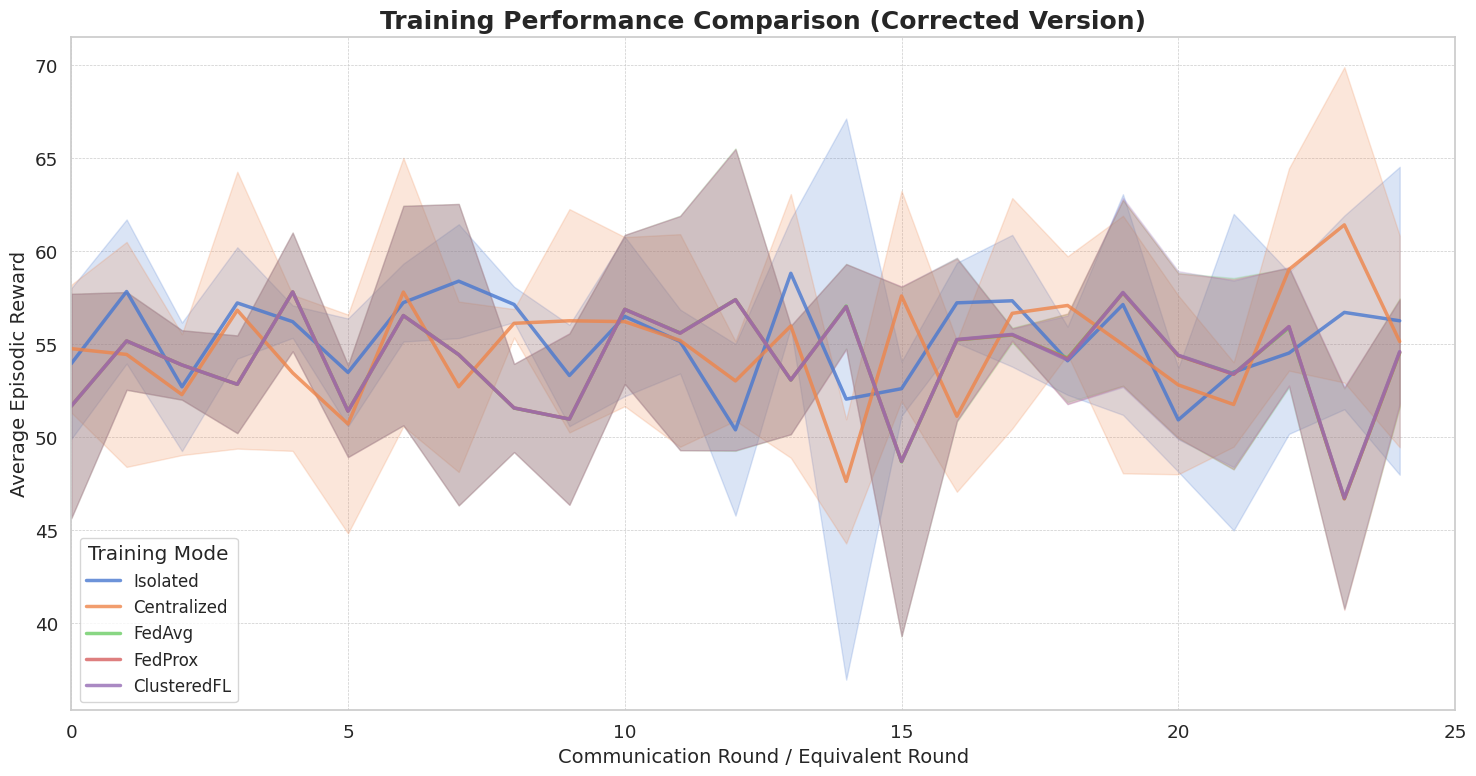

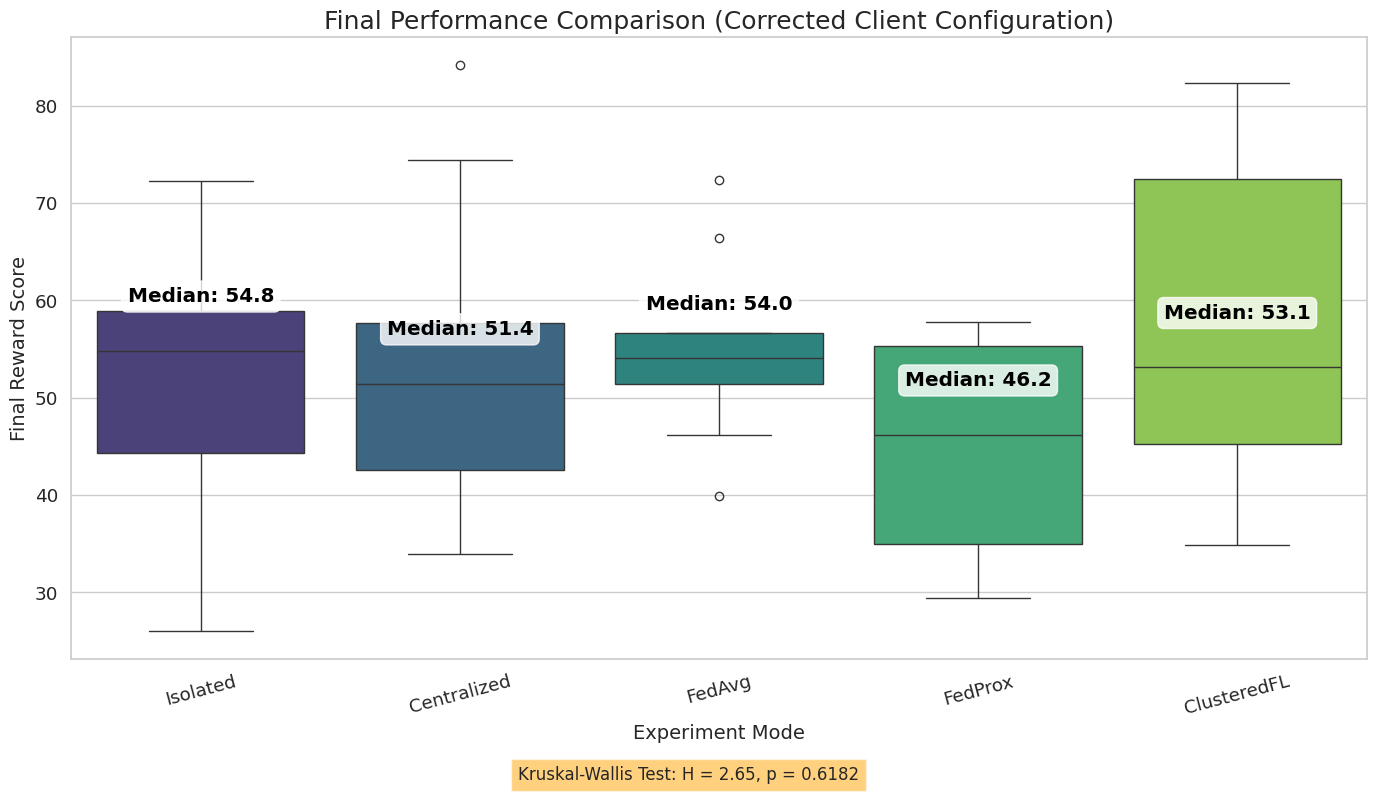

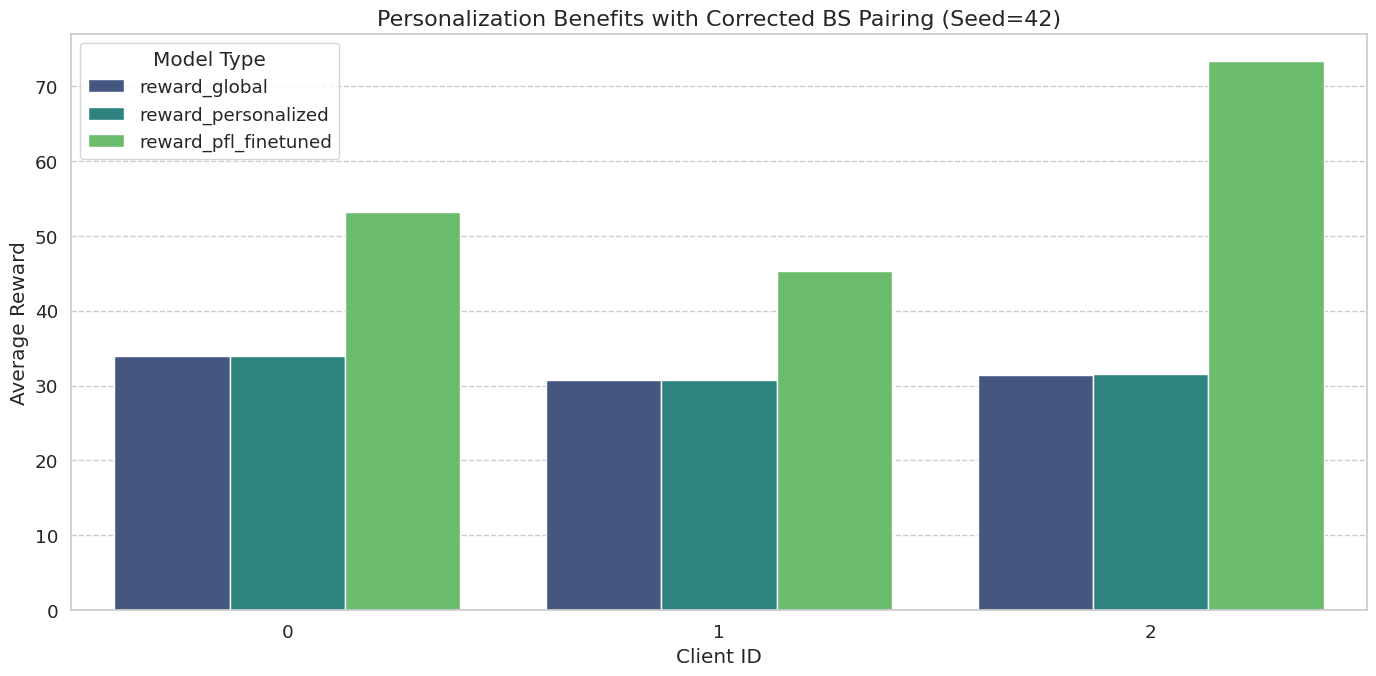

✅ Cell 9: 結果視覺化（修正版）完成。


In [10]:
# @title Cell 9: 📊 結果視覺化（修正版）
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"❌ 找不到結果目錄: {base_output_dir}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    # 先嘗試加載配置文件
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"🟡 警告: 讀取設定檔失敗: {e}")

    for seed_folder in sorted(os.listdir(base_output_dir)):
        if not seed_folder.startswith('seed_'): continue
        try:
            seed = int(seed_folder.split('_')[1])
        except (ValueError, IndexError):
            continue

        for mode_folder in sorted(os.listdir(os.path.join(base_output_dir, seed_folder))):
            exp_path = os.path.join(base_output_dir, seed_folder, mode_folder)
            if not os.path.isdir(exp_path): continue

            eval_files = glob.glob(os.path.join(exp_path, '*_evaluation_results.csv'))
            history_files = glob.glob(os.path.join(exp_path, '*_training_history.csv'))
            privacy_files = glob.glob(os.path.join(exp_path, '*_privacy_costs.csv'))

            def read_and_append(file_list, data_list, mode_name, seed_val):
                if not file_list: return
                file_path = file_list[0]
                try:
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        df = pd.read_csv(file_path)
                        df['mode'] = mode_name
                        df['seed'] = seed_val
                        data_list.append(df)
                except Exception as e:
                    print(f"🟡 警告: 讀取檔案失敗: {file_path}, {e}")

            read_and_append(eval_files, all_evals, mode_folder, seed)
            read_and_append(history_files, all_histories, mode_folder, seed)
            read_and_append(privacy_files, all_privacies, mode_folder, seed)

    return (pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()), \
           (pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()), \
           (pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()), \
           config_data

# --- 視覺化設定 ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
BASE_OUTPUT_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim/outputs_3clients_corrected"
FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("❌ 找不到任何結果檔案，無法繪圖。請確認 Cell 8 已成功執行且路徑正確。")
else:
    SEEDS = [42, 2024, 888]
    mode_order = ["Isolated", "Centralized", "FedAvg", "FedProx", "ClusteredFL"]

    print(f"✅ 成功載入 {len(eval_df['seed'].unique()) if not eval_df.empty else 0} 次執行的結果。")

    # --- 圖 1: 訓練歷史比較 ---
    if not history_df.empty:
        plt.figure(figsize=(15, 8))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=mode_order, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)

        plt.title('Training Performance Comparison (Corrected Version)', fontsize=18, weight='bold')
        plt.xlabel('Communication Round / Equivalent Round', fontsize=14)
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim(0, 25)
        plt.tight_layout()

        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_corrected.png'), dpi=300)
        plt.show()

    # --- 圖 2: 最終性能比較 ---
    if not eval_df.empty:
        eval_to_plot = eval_df.rename(columns={'reward_pfl_finetuned': 'Final Reward Score'})

        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=mode_order, palette="viridis")

        # 添加中位數標註
        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(mode_order)
        for xtick in ax.get_xticks():
            if xtick < len(mode_order):
                mode_name = mode_order[xtick]
                median_val = medians.get(mode_name)
                if pd.notna(median_val):
                    ax.text(xtick, median_val + 5, f'Median: {median_val:.1f}',
                            horizontalalignment='center', size='medium',
                            color='black', weight='semibold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.title('Final Performance Comparison (Corrected Client Configuration)', fontsize=18)
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score', fontsize=14)
        plt.xticks(rotation=15)

        # 統計檢驗
        groups = [eval_to_plot['Final Reward Score'][eval_to_plot['mode'] == m].dropna()
                 for m in mode_order if m in eval_to_plot['mode'].unique()]
        if len(groups) > 1:
            h_stat, p_value = stats.kruskal(*groups)
            plt.figtext(0.5, 0.01, f'Kruskal-Wallis Test: H = {h_stat:.2f}, p = {p_value:.4f}',
                        ha='center', fontsize=12,
                        bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_corrected.png'), dpi=300)
        plt.show()

    # --- 圖 3: 個人化效益分析 ---
    if not eval_df.empty:
        first_seed = SEEDS[0]
        cfl_eval = eval_df[(eval_df['mode'] == 'ClusteredFL') & (eval_df['seed'] == first_seed)]

        if not cfl_eval.empty:
            cfl_melted = cfl_eval.melt(
                id_vars=['client_id'],
                value_vars=['reward_global', 'reward_personalized', 'reward_pfl_finetuned'],
                var_name='Model Type', value_name='Average Reward'
            )

            plt.figure(figsize=(14, 7))
            sns.barplot(data=cfl_melted, x='client_id', y='Average Reward',
                       hue='Model Type', palette='viridis')

            plt.title(f'Personalization Benefits with Corrected BS Pairing (Seed={first_seed})', fontsize=16)
            plt.xlabel('Client ID')
            plt.ylabel('Average Reward')
            plt.legend(title='Model Type')
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()

            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit_corrected.png'), dpi=300)
            plt.show()

    # --- 圖 4: 隱私成本追蹤 ---
    if not privacy_df.empty:
        privacy_to_plot = privacy_df[privacy_df['mode'].isin(['FedAvg', 'FedProx', 'ClusteredFL'])]

        if not privacy_to_plot.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=privacy_to_plot, x='round', y='epsilon', hue='mode',
                         errorbar=('sd', 1), linewidth=2.5)

            # 添加目標epsilon線
            if loaded_config and 'dp_target_epsilon' in loaded_config:
                target_eps = loaded_config['dp_target_epsilon']
                plt.axhline(y=target_eps, color='r', linestyle='--',
                           label=f'Target ε = {target_eps}')

            plt.title('Privacy Budget Consumption (Corrected DP Implementation)', fontsize=16)
            plt.xlabel('Communication Round', fontsize=14)
            plt.ylabel('Privacy Loss ε (Epsilon)', fontsize=14)
            plt.legend()
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()

            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'privacy_cost_corrected.png'), dpi=300)
            plt.show()

print("✅ Cell 9: 結果視覺化（修正版）完成。")
